In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential

In [ ]:
data=pd.read_csv(r"/content/Weather Data.csv")

In [ ]:


data.isnull().sum()

,0
Date/Time,0
Temp_C,0
Dew Point Temp_C,0
Rel Hum_%,0
Wind Speed_km/h,0
Visibility_km,0
Press_kPa,0
Weather,0


In [ ]:
data['Date/Time'] = pd.to_datetime(data['Date/Time'],errors='coerce', utc=True)



In [ ]:
# Set 'Date/Time' as the index
data.set_index('Date/Time', inplace=True)

# Feature Engineering
# Extract time-based features
data['hour'] = data.index.hour
data['day'] = data.index.day
data['month'] = data.index.month
data['weekday'] = data.index.weekday


In [ ]:

numerical_columns = [
    'Temp_C', 'Dew Point Temp_C', 'Rel Hum_%', 'Wind Speed_km/h	',
    'Visibility_km', 'Press_kPa','Weather'
]

In [ ]:
print(data.columns)

Index(['Temp_C', 'Dew Point Temp_C', 'Rel Hum_%', 'Wind Speed_km/h',
       'Visibility_km', 'Press_kPa', 'Weather', 'hour', 'day', 'month',
       'weekday'],
      dtype='object')


In [ ]:


for col in numerical_columns:
    Q1 =data[col].quantile(0.25)  # 25th percentile
    Q3 = data[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Clip values outside the bounds
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)


KeyError: 'Wind Speed_km/h\t'

In [ ]:
# Create a boxplot for numerical columns after handling outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=data[numerical_columns], orient='h', palette="Set2")
plt.title("Boxplot of Numerical Features After Outlier Handling")
plt.xlabel("Value")
plt.ylabel("Features")
plt.show()

**Univariate analysis**

In [ ]:
target_column = 'Temp_C'
data = data[[target_column]]


In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:
# **Data Preparation for Multi-Step Forecasting**
def create_multistep_sequences(data, input_steps, output_steps):
    """
    Create sequences for multi-step forecasting.
    :param data: Scaled data as a numpy array
    :param input_steps: Number of time steps as input
    :param output_steps: Number of future steps to predict
    :return: X (input sequences), y (output sequences)
    """
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(y)


In [ ]:
# Define input-output sequence lengths
input_steps = 30  # Use past 30 time steps as input
output_steps = 10  # Predict the next 10 time steps

In [ ]:
# Create sequences
X, y = create_multistep_sequences(scaled_data, input_steps, output_steps)

# Split data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

**vector ouput model**

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

In [ ]:
 #Build the Vector Output LSTM Model
n_features = X_train.shape[2]  # Number of features
n_future_steps = y_train.shape[1]  # Number of future steps to predict

In [ ]:
from sklearn.model_selection import ParameterGrid

# Example Hyperparameters
param_grid = {
    'lstm_units': [32, 64],
    'dropout': [0.2, 0.3],
    'learning_rate': [0.001, 0.0005]
}

grid = list(ParameterGrid(param_grid))

for params in grid:
    model = Sequential([
        LSTM(params['lstm_units'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(params['dropout']),
        LSTM(params['lstm_units']),
        Dropout(params['dropout']),
        Dense(y_train.shape[1])  # Output layer for vector
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']), loss='mse')
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)
    print(f"Completed training with params: {params}")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0916 - val_loss: 0.0045
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0166 - val_loss: 0.0052
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0131 - val_loss: 0.0043
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0110 - val_loss: 0.0045
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0103 - val_loss: 0.0044
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.0096 - val_loss: 0.0044
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0085 - val_loss: 0.0040
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0074 - val_loss: 0.0040
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0060 - val_loss: 0.0032
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0056 - val_loss: 0.0030
Completed training with params: {'dropout': 0.2, 'learning_rate': 0.001, 'lstm_units': 32}
Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s

In [ ]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                       │ (None, 30, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_37 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,712 (592.63 KB)

 Trainable params: 50,570 (197.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 101,142 (395.09 KB)

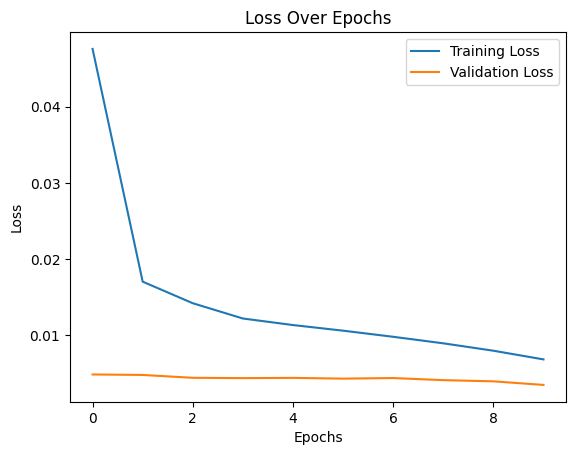

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

# Predict on test data
y_pred = model.predict(X_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Flatten the arrays for evaluation
y_test_flat = y_test.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

# 1. Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_flat, y_pred_flat)
print("Mean Absolute Error (MAE):", mae)

# 2. Mean Squared Error (MSE)
mse = mean_squared_error(y_test_flat, y_pred_flat)
print("Mean Squared Error (MSE):", mse)


Mean Absolute Error (MAE): 0.043428310061451106
Mean Squared Error (MSE): 0.003495704345356798


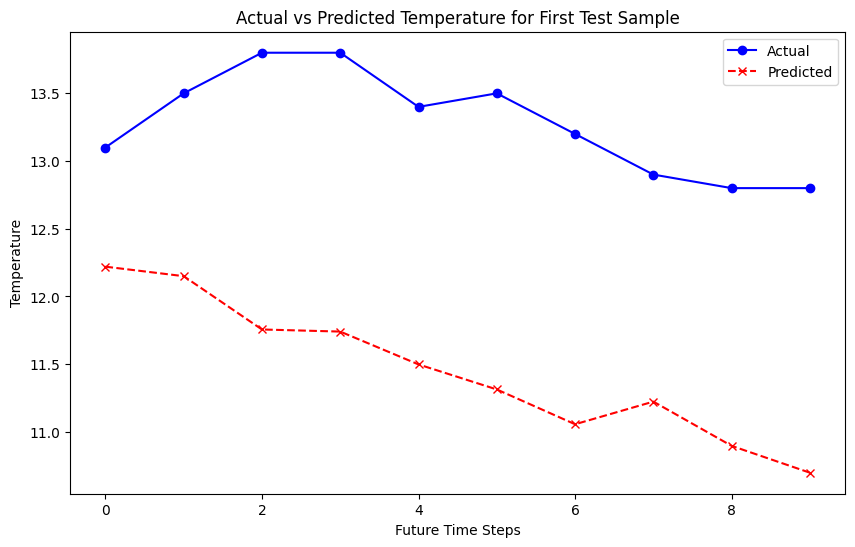

In [ ]:
# Inverse transform predictions and actual values
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

y_test_rescaled = scaler.inverse_transform(y_test_reshaped).reshape(y_test.shape)
y_pred_rescaled = scaler.inverse_transform(y_pred_reshaped).reshape(y_pred.shape)

# Visualize the results for the first test sample
plt.figure(figsize=(10, 6))
plt.plot(range(output_steps), y_test_rescaled[0], label="Actual", marker='o', color='blue')
plt.plot(range(output_steps), y_pred_rescaled[0], label="Predicted", marker='x', color='red', linestyle='--')
plt.title("Actual vs Predicted Temperature for First Test Sample")
plt.xlabel("Future Time Steps")
plt.ylabel("Temperature")
plt.legend()
plt.show()


**Encoder Decoder LSTM Model**

In [ ]:
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam

In [ ]:
 #Select the target variable
temperature = data['Temp_C'].values.reshape(-1, 1)
# Adjust the column name if needed
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
temperature_scaled = scaler.fit_transform(temperature)

In [ ]:
# Function to create sequences for encoder-decoder
def create_sequences(data, input_steps, output_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(y)

# Parameters
input_steps = 24  # Number of past hours to consider
output_steps = 12  # Number of future hours to predict

# Create sequences
X, y = create_sequences(temperature_scaled, input_steps, output_steps)

# Split into training and testing datasets
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [ ]:
# Define Encoder-Decoder Model
encoder_inputs = Input(shape=(input_steps, 1))
encoder_lstm = LSTM(64, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(output_steps, 1))
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(1, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [ ]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 24, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_13            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_20 (LSTM)            │ [(None, 64), (None,    │         16,896 │ input_layer_12[0][0]   │
│                           │ 64), (None, 64)]       │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_21 (LSTM)            │ [(None, 12, 64),       │         16,896 │ input_layer_13[0][0],  │
│                           │ (None, 64), (None,     │                │ lstm_20[0][1],         │
│                           │ 64)]                   │                │ lstm_20[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 12, 1)          │             65 │ lstm_21[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,857 (132.25 KB)

 Trainable params: 33,857 (132.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
decoder_input_train = np.zeros((y_train.shape[0], output_steps, 1))
decoder_input_test = np.zeros((y_test.shape[0], output_steps, 1))

In [ ]:
history = model.fit(
    [X_train, decoder_input_train], y_train,
    epochs=20,
    batch_size=32,
    validation_data=([X_test, decoder_input_test], y_test)
)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0555 - val_loss: 0.0059
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

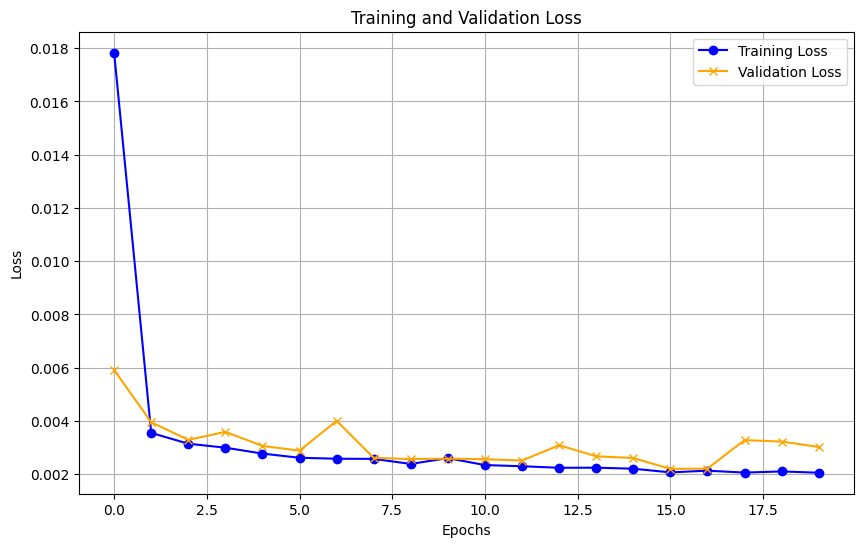

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Make predictions
predicted = model.predict([X_test, decoder_input_test])

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [ ]:
y_test = y_test.reshape(-1, 1)
predicted= predicted.reshape(-1, 1)
min_len = min(len(y_test), len(predicted))
actual_flat = y_test[:min_len]
predicted_flat = predicted[:min_len]


In [ ]:
print(len(actual_flat))  # Should be the same as len(predicted_flat)
print(len(predicted_flat))  # Should be the same as len(actual_flat)


20988
20988


In [ ]:


# Calculate metrics
mae = mean_absolute_error(actual_flat, predicted_flat)
mse = mean_squared_error(actual_flat, predicted_flat)
rmse = np.sqrt(mse)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Absolute Error (MAE): 0.0399
Mean Squared Error (MSE): 0.0030
Root Mean Squared Error (RMSE): 0.0550


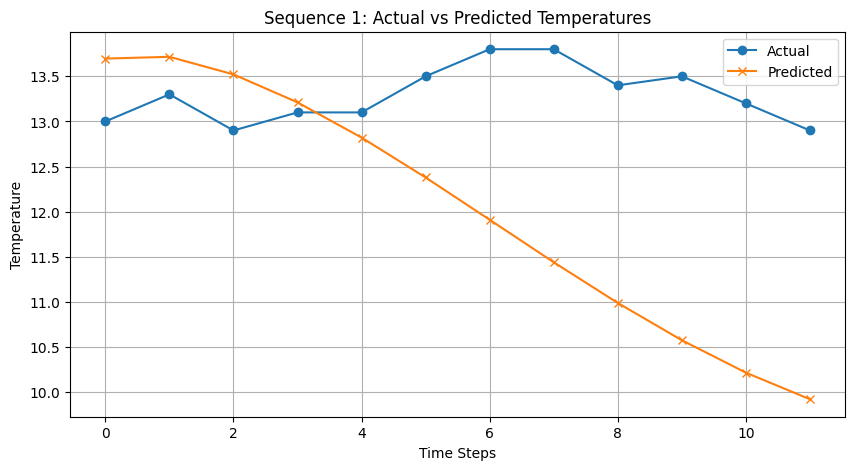

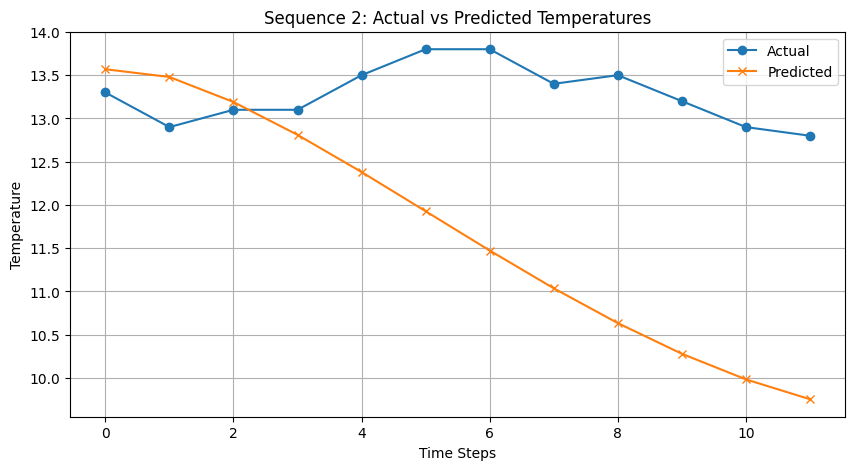

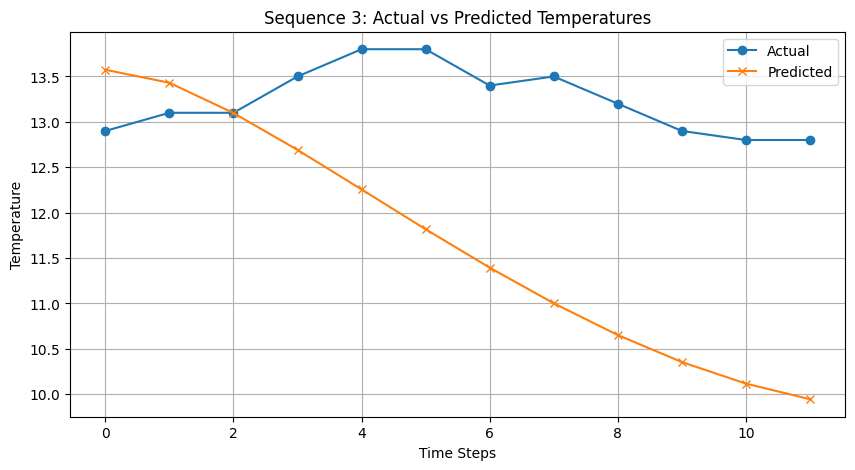

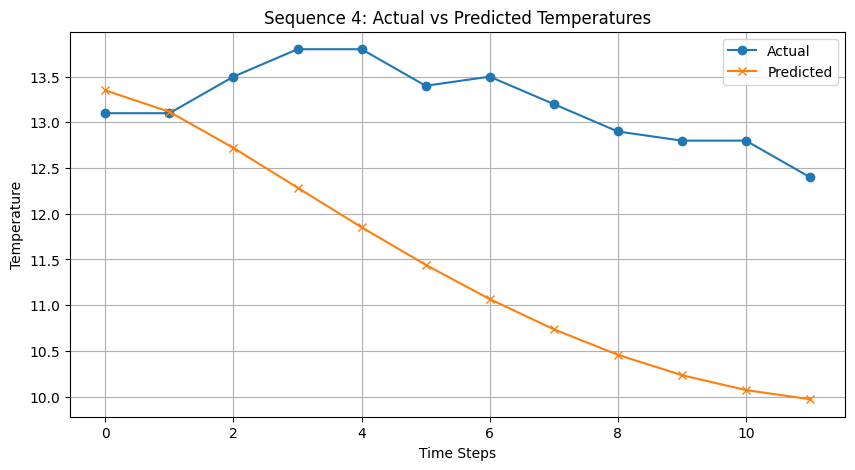

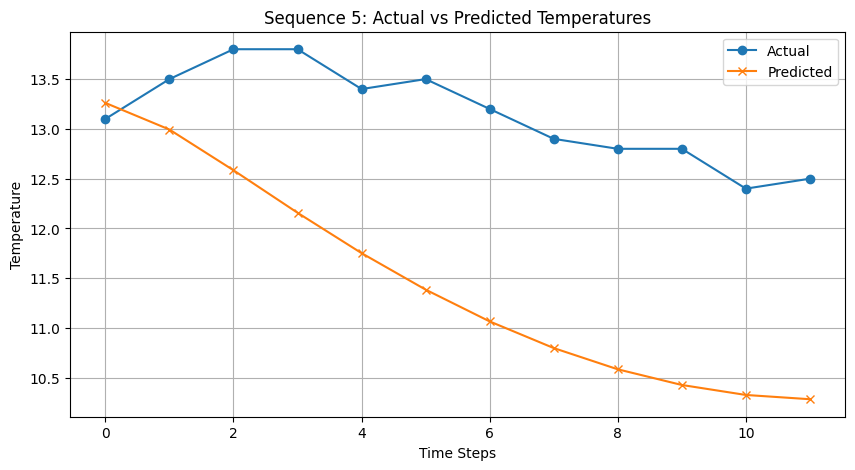

In [ ]:
# Invert scaling for predicted and actual values
predicted = scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(-1, output_steps)
actual = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1, output_steps)
# Plot actual vs predicted for the first output sequence
for i in range(min(5, len(actual))):  # Plot the first 5 examples (customize if needed)
    plt.figure(figsize=(10, 5))
    plt.plot(actual[i], label='Actual', marker='o')
    plt.plot(predicted[i], label='Predicted', marker='x')
    plt.title(f'Sequence {i+1}: Actual vs Predicted Temperatures')
    plt.xlabel('Time Steps')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid()

**Multi variate analysis**

In [ ]:
# Lag features: Include past values of Temp_C and Press_kPa
lags = 3
for lag in range(1, lags + 1):
    data[f'Temp_C_lag_{lag}'] = data['Temp_C'].shift(lag)
    data[f'Press_kPa_lag_{lag}'] = data['Press_kPa'].shift(lag)

# Drop rows with NaN values caused by lagging
data.dropna(inplace=True)

# Define input features (X) and target variables (y)
features = [col for col in data.columns if col not in ['Temp_C', 'Press_kPa', 'Weather']]
X = data[features].values
y = data[['Temp_C', 'Press_kPa']].values

In [ ]:
# Standardize the features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Prepare data for LSTM (time-series format)
def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)


In [ ]:
TIME_STEPS = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(TIME_STEPS, X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(2)  # Output layer for Temp_C and Press_kPa
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,

    verbose=1
)

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.3060 - val_loss: 0.1421
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0955 - val_loss: 0.1234
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0754 - val_loss: 0.0663
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0680 - val_loss: 0.0635
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0596 - val_loss: 0.0757
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0582 - val_loss: 0.0718
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0553 - val_loss: 0.0527
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0554 - val_loss: 0.0637
Epoch 9/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0501 - val_loss: 0.0523
Epoch 10/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0510 - val_loss: 0.0518
Epoch 11/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0482 - val_loss: 0.0509
Epoch 12/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
 #Evaluate the model
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [ ]:
# Calculate Mean Squared Error
mse_temp = mean_squared_error(y_test_actual[:, 0], y_pred[:, 0])
mse_press = mean_squared_error(y_test_actual[:, 1], y_pred[:, 1])

print(f"Mean Squared Error for Temperature: {mse_temp:.2f}")
print(f"Mean Squared Error for Pressure: {mse_press:.2f}")


Mean Squared Error for Temperature: 4.05
Mean Squared Error for Pressure: 0.02


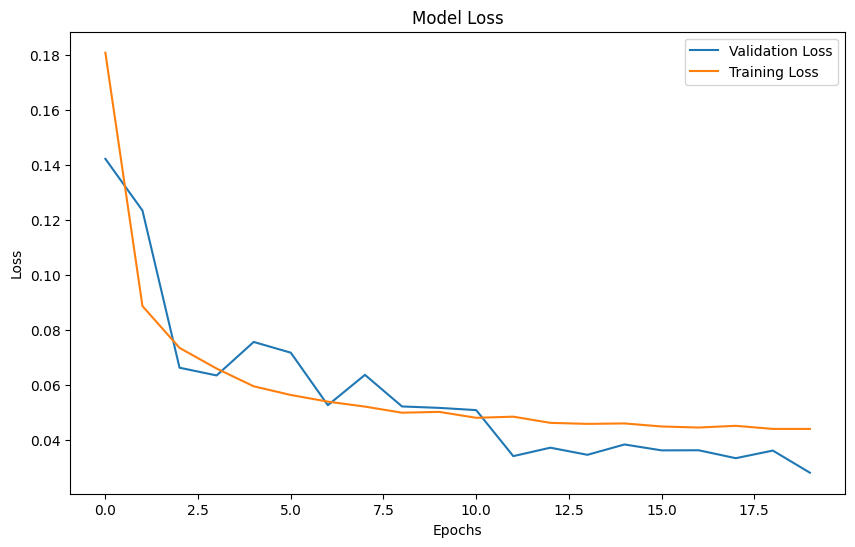

In [ ]:
# Plot validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

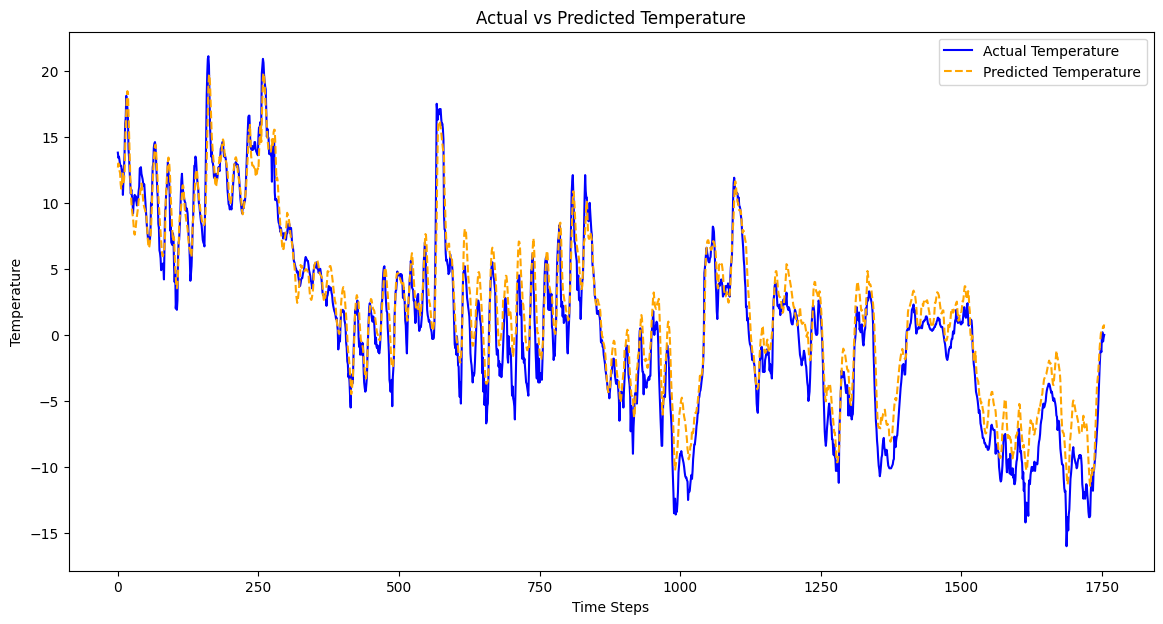

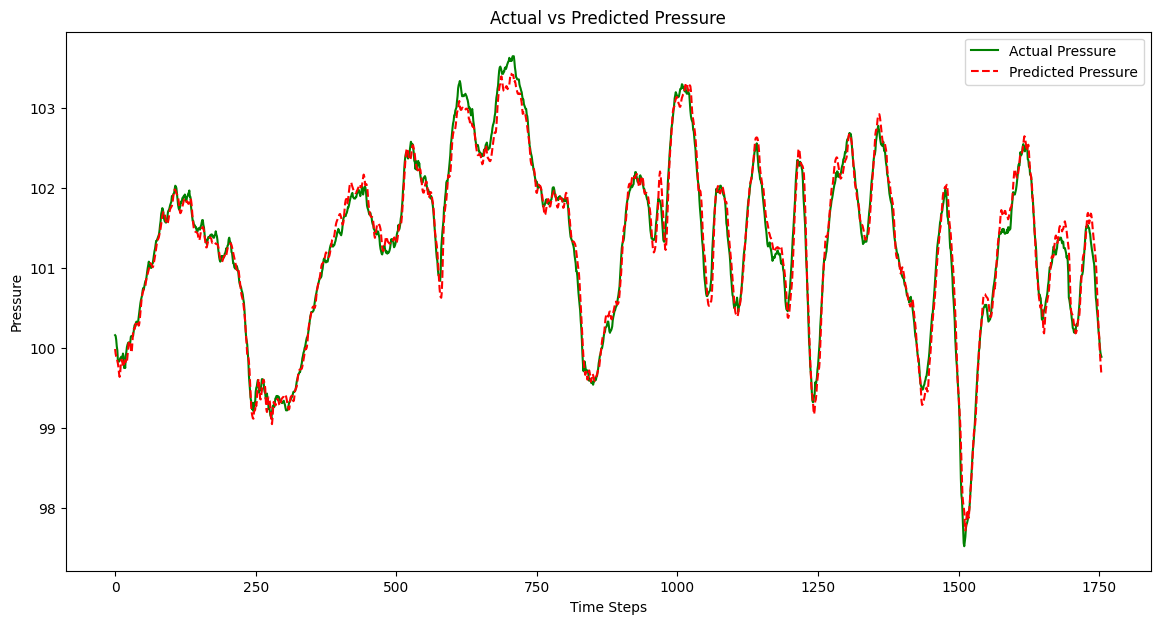

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual[:, 0], label='Actual Temperature', color='blue')
plt.plot(y_pred[:, 0], label='Predicted Temperature', color='orange', linestyle='dashed')
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_test_actual[:, 1], label='Actual Pressure', color='green')
plt.plot(y_pred[:, 1], label='Predicted Pressure', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Pressure')
plt.xlabel('Time Steps')
plt.ylabel('Pressure')
plt.legend()
plt.show()